## importing dataset, splitting tracks

In [1]:
import os
import sys
import numpy as np

proj_base_path = '../../../'
data_base_path = '../../../datasets'
models_base_path = '../../../pretrained_models'
sys.path.append(os.path.join(os.getcwd(), proj_base_path))

dataset_path = 'numpy/pokemon100ms_no_vel_transposed/meta/'
dataset_file = '_dicted_dataset_ignore_ratio=0.05.npy'
word_vectors_file = '_word_vectors_1000_ignore_ratio=0.05.wv'

track_path = os.path.join(data_base_path, dataset_path, dataset_file)
word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)

track = np.load(track_path)

track

array(['D#3,C4', 'D#3,C4', 'D#3,C4', ..., '<UNKNOWN>', '<UNKNOWN>',
       '<TRACK_END>'], dtype='<U27')

In [2]:
from src.data_processing.embedding_sparse_notes.common import TRACK_END, UNKNOWN_FRAME

track_split_points = np.where(track == TRACK_END)[0]

# + 1, so split happens after <TRACK_END>, [:-1] to skip last, empty partition
tracks = [t.tolist() for t in np.split(track, track_split_points + 1)][:-1]
# tracks is now a list of lists of frames

## loading embedding + encoding dataset

In [3]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load(word_vectors_path, mmap='r')

def vectorize_frame(frame):
    return wv[frame] if frame in wv else wv[UNKNOWN_FRAME]

vectorized_tracks = [np.array([vectorize_frame(f) for f in t]) for t in tracks]
for v in vectorized_tracks: print(v.shape, end=', ')

(2197, 16), (2197, 16), (1920, 16), (361, 16), (552, 16), (1008, 16), (533, 16), (552, 16), (552, 16), (533, 16), (1008, 16), (361, 16), (2197, 16), (2197, 16), (2197, 16), (361, 16), (1920, 16), (552, 16), (1008, 16), (552, 16), (717, 16), (717, 16), (552, 16), (1008, 16), (552, 16), (1920, 16), (361, 16), (2197, 16), (2197, 16), (1920, 16), (552, 16), (1622, 16), (717, 16), (386, 16), (1008, 16), (1622, 16), (552, 16), (552, 16), (1622, 16), (1008, 16), (386, 16), (717, 16), (552, 16), (1622, 16), (1920, 16), (361, 16), (2197, 16), (2197, 16), (1920, 16), (361, 16), (552, 16), (717, 16), (1008, 16), (386, 16), (552, 16), (1008, 16), (1008, 16), (552, 16), (386, 16), (1008, 16), (1622, 16), (552, 16), (361, 16), (1920, 16), (2197, 16), (717, 16), (361, 16), (2197, 16), (1008, 16), (533, 16), (533, 16), (386, 16), (386, 16), (533, 16), (533, 16), (361, 16), (2197, 16), (1008, 16), (361, 16), (717, 16), (717, 16), (1622, 16), (2197, 16), (1920, 16), (533, 16), (361, 16), (533, 16), (533

In [4]:
def dataset_gen(tracks, window_size_range=(20, 300), batch_size=16):
    """
    tracks - list of np.arrays of shape (track_length, frame_size)
    window_size - length of generated batch
    batch_size - number of sequences in batch
    """
    max_window_size = min([len(t) for t in tracks]) - 3
    while True:
        window_size = np.random.randint(window_size_range[0], min(max_window_size, window_size_range[1]))
        # select #batch_size tracks
        selected_track_indicies = [np.random.randint(0, len(tracks)) for _ in range(batch_size)]
        # select sequence starting point for each track
        sequence_indicies = [np.random.randint(0, len(tracks[sti]) - window_size - 2)
                             for sti in selected_track_indicies]
        
        
        # create slices for x and y
        x_slice = lambda seqi: np.s_[seqi:seqi + window_size]
        y_slice = lambda seqi: np.s_[seqi + 1:seqi + window_size + 1]
        
        x = [tracks[sti][x_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]
        y = [tracks[sti][y_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]

        yield np.stack(x), np.stack(y)
        
x, y = next(dataset_gen(vectorized_tracks, (10, 50), 5))
x.shape, y.shape

((5, 31, 16), (5, 31, 16))

## Setting up model

In [5]:
from tensorflow import keras as K

INPUT_SIZE = 16
HIDDEN_SIZE = 128
OUTPUT_SIZE = INPUT_SIZE

BATCH_SIZE = 16
WINDOW_SIZE_RANGE = (20, 300)

INPUT_SHAPE = (None, INPUT_SIZE)
# None allows for variable seq_length between batches

#### load existing model

In [6]:
# or load saved model
model_path = 'lstm/embedded_16_128md_e1_t2019-10-08T18:06:50.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

OSError: Unable to open file (unable to open file: name = '../../../pretrained_models/lstm/embedded_16_128md_e1_t2019-10-08T18:06:50.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

#### or create new one

In [6]:
model = K.models.Sequential([
    K.layers.LSTM(
        HIDDEN_SIZE,
        input_shape=INPUT_SHAPE,
        return_sequences=True,
    ),
    K.layers.Dense(
        OUTPUT_SIZE,
    ),
])

W1010 19:02:01.902128 4577134016 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam', 
    metrics=["mean_squared_error"],
)

#### define training callbacks

In [8]:
from src.training.common.training_callbacks import ModelAndLogSavingCallback, GeneratingAndPlottingCallback

# logging callback
logging_path = 'lstm'
experiment_name = f'embedded_{INPUT_SIZE}_{HIDDEN_SIZE}'
experiment_path = os.path.join(models_base_path, logging_path, experiment_name)
os.makedirs(experiment_path, exist_ok=True)
print(f'saving checkpoints and logs to {experiment_path}')

# logging disabled for now
log_callback = ModelAndLogSavingCallback(model, experiment_path)

# generating callback
from src.generating.generating import recurrent_generate
from src.generating.embedded_generating_seeds import seed_generators
from src.data_processing.common.helpers import pipe
from src.data_processing.embedding_sparse_notes.reverse_transform import np2sparse

SEED_LENGTH = 20
GENERATED_SEQ_LENGTH = 400
GENERATING_WINDOW_SIZE = 100
METHOD = 'const_frame_seed_noise'

seed_generator = lambda: seed_generators[METHOD](
    SEED_LENGTH, INPUT_SIZE, word_vectors=wv, batch_size=BATCH_SIZE)

sample_generator = lambda model, seed: recurrent_generate(
    model, seed, GENERATED_SEQ_LENGTH, GENERATING_WINDOW_SIZE, is_binary=False)

sparse_sample_generator = lambda model, seed: pipe(
    sample_generator(model, seed),
    lambda batch_of_samples: [np2sparse(sample, wv)[0] for sample in batch_of_samples]
)

print(f'generating sequences of {GENERATED_SEQ_LENGTH} using {METHOD}')

gen_callback = GeneratingAndPlottingCallback(model, sparse_sample_generator, seed_generator)

saving checkpoints and logs to ../../../pretrained_models/lstm/embedded_16_128
generating sequences of 400 using const_frame_seed_noise


#### training

In [9]:
# pre training code
from time import time
epochs_elapsed = 0
minutes_elapsed = 0

data_gen = dataset_gen(vectorized_tracks, WINDOW_SIZE_RANGE, BATCH_SIZE)
test_gen = dataset_gen(vectorized_tracks, WINDOW_SIZE_RANGE, BATCH_SIZE)

W1010 19:02:05.672058 4577134016 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 8/10 [=======================>......] - ETA: 0s - loss: 16.5788 - mean_squared_error: 16.9124

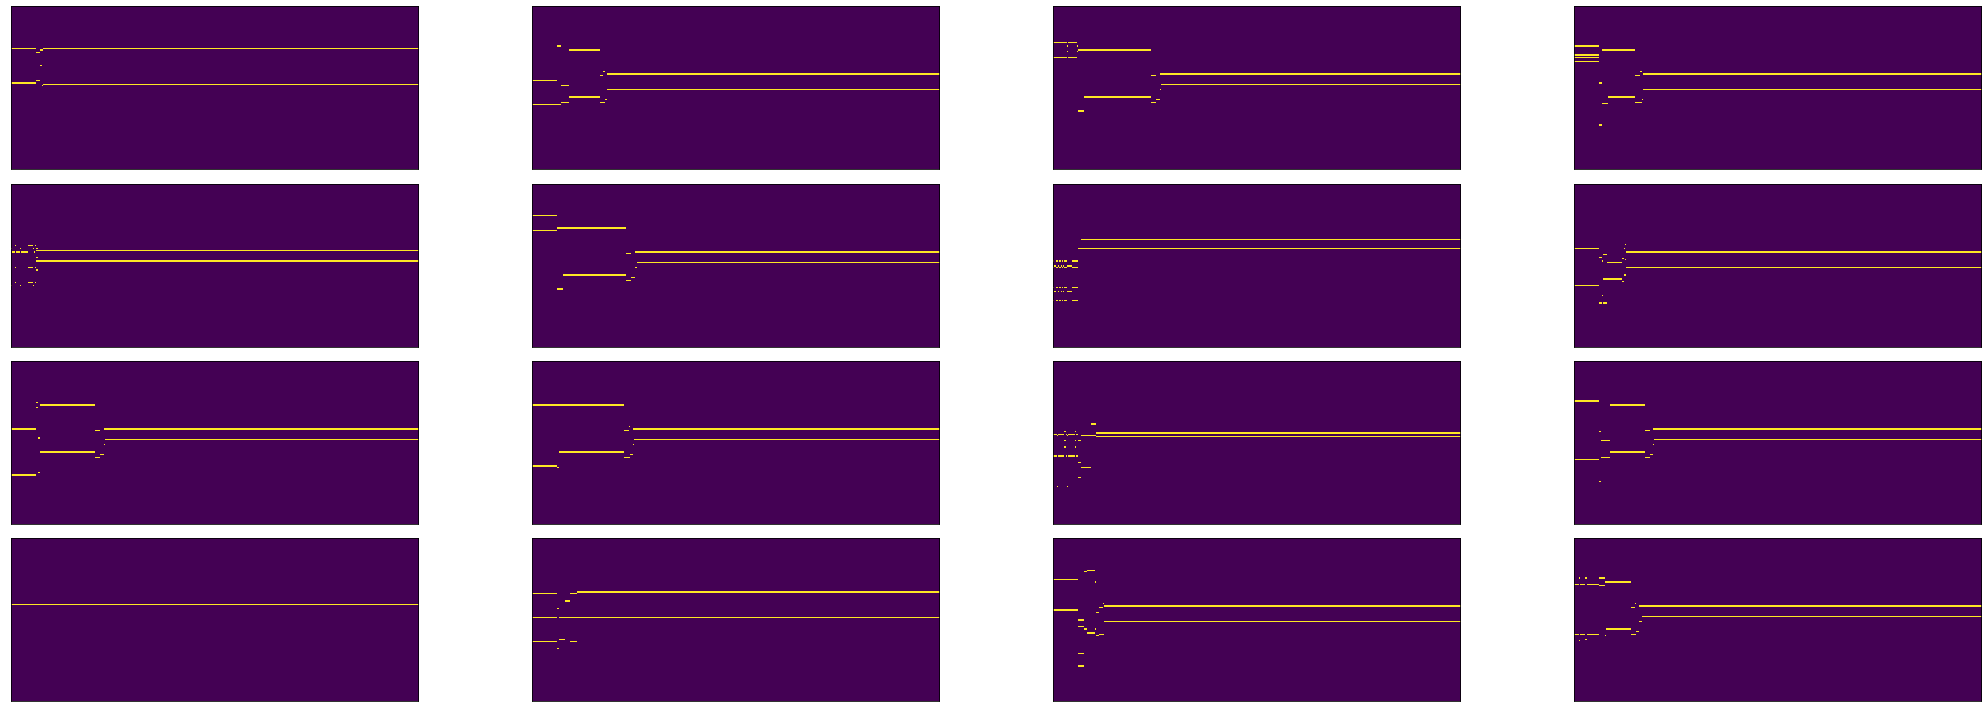

10/10 [==============================] - 7s 672ms/step - loss: 16.3740 - mean_squared_error: 16.7515 - val_loss: 17.1380 - val_mean_squared_error: 17.1380


In [10]:
EPOCHS = 1
STEPS_PER_EPOCH = 10
TEST_STEPS = 1

start_time = time()
model.fit_generator(
    data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=TEST_STEPS,
    callbacks=[log_callback, gen_callback]
)

minutes_elapsed += (time() - start_time) // 60
epochs_elapsed += EPOCHS